In [1]:
import math
import h5py
import numpy as np
import netCDF4 as nc
#from netCDF4 import Dataset
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib.pyplot as plt
import time
import pandas as pd
import datetime
import random
import copy

import os
import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import from_numpy
from torch import manual_seed as torch_manual_seed
from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn
import torch.optim as optim


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
from functools import partial

2.1.0a0+29c30b1


# CNN

### Prepare Data for CNN in PyTorch

In [3]:
ds2 = xr.open_dataset("Detrended_SST.nc", decode_times=False)
#ds2 = xr.open_dataset("/content/drive/MyDrive/CaliforniaClimateCapstone/Data/Detrended_SST.nc", decode_times=False)
ds2

<xarray.Dataset> Size: 2GB
Dimensions:  (lat: 192, lon: 288, time: 7400)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 59kB 0 366 731 1096 1461 ... 25568 25933 26298 26664
Data variables:
    SST      (time, lat, lon) float32 2GB ...

In [4]:
PRECT = pd.read_csv('Detrended_PRECT_reordered.csv')
#PRECT = pd.read_csv('/content/drive/MyDrive/CaliforniaClimateCapstone/Data/Detrended_PRECT.csv')
PRECT = PRECT.set_index(['simulation', 'year', 'region'])
PRECT.head()

PRECT
simulation year region            
1001.001   1940 Central   1.696816
                North    -4.384861
                South     2.359652
           1941 Central   7.414276
                North    15.164542

In [5]:
y = PRECT.to_numpy()
y.shape

(22200, 1)

In [6]:
y = y.reshape(-1, 3)
y = y[:, 0]
y.shape

(7400,)

In [7]:
y_reshaped = y.reshape(100, 74, 1)
y_reshaped.shape

(100, 74, 1)

In [8]:
X = ds2['SST'].to_numpy()
X.shape

(7400, 192, 288)

In [9]:
X_reshaped = X.reshape(100, 74, 192, 288)
X_reshaped.shape

(100, 74, 192, 288)

In [10]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

In [11]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.1, random_state=49)#49
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=.1/.9, random_state=49)

#Create Dataloader Objects for PyTorch
#BATCH_SIZE = 16
BATCH_SIZE = 32

X_train = from_numpy(X_train).float()
y_train = from_numpy(y_train).float()
X_val = from_numpy(X_val).float()
y_val = from_numpy(y_val).float()
X_test = from_numpy(X_test).float()
y_test = from_numpy(y_test).float()

print("After train/val/test split, before reshaping")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

X_train = X_train.view(-1, 192, 288)
X_test = X_test.view(-1, 192, 288)
X_val = X_val.view(-1, 192, 288)
y_train = y_train.view(-1, 1)
y_test = y_test.view(-1, 1)
y_val = y_val.view(-1, 1)

dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

dataset_valid = TensorDataset(X_val, y_val)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False)

dataset_test = TensorDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

#Check shape of resulting objects
print("After train/val/test split, after reshaping")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)


After train/val/test split, before reshaping
torch.Size([80, 74, 192, 288])
torch.Size([10, 74, 192, 288])
torch.Size([10, 74, 192, 288])
torch.Size([80, 74, 1])
torch.Size([10, 74, 1])
torch.Size([10, 74, 1])
After train/val/test split, after reshaping
torch.Size([5920, 192, 288])
torch.Size([740, 192, 288])
torch.Size([740, 192, 288])
torch.Size([5920, 1])
torch.Size([740, 1])
torch.Size([740, 1])


In [12]:
for batch in dataloader_train:
    predictor_batch, target_batch = batch
    print(predictor_batch.shape)
    break

torch.Size([32, 192, 288])


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Build CNN

In [14]:
class Net(nn.Module):
    def __init__(self, p, p2d):
        super(Net, self).__init__()
        self.p = p
        self.p2d = p2d
        self.conv1 = nn.Conv2d(1, 32, stride = (3,3), kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, stride = (2,2), kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8 * 4 * 6, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)  # 1 output value
        self.dropout2d = nn.Dropout2d(p = self.p2d)
        self.dropout = nn.Dropout(p = self.p)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout2d(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout2d(x)
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 8 * 4 * 6)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model=Net(0.1, 0.1)
model

#R2 0.143. p = 0.2, lr = 0.0001, no batchnorm, same P for both, weights saved 
# test and valid mse around 19.3-4

# Doing hyperparam tuning on this one

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=192, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (dropout2d): Dropout2d(p=0.1, inplace=False)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [15]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

12825

### Train CNN

In [16]:
train_losses = []
valid_losses = []

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    epoch_loss = 0  # Initialize epoch loss
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        X = X.unsqueeze(1)
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        # Compute prediction and loss
        pred = model(X)

        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

        if batch % 36 == 0:
            loss, current = loss.item(), batch * BATCH_SIZE + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    epoch_avg_loss = epoch_loss / num_batches
    train_losses.append(epoch_avg_loss)


def test_valid_loop(dataloader, model, loss_fn, valid = True):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            # Prepare Data
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            X = X.unsqueeze(1)
            # make predictions and calculate loss and accuracy
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    
    # Print either Validation or Test error
    if valid:
      print(f"Validation Loss: {test_loss:>8f} \n")
      valid_losses.append(test_loss)
    else:
      print(f"Test Loss: {test_loss:>8f} \n")

#### Hyperparameter Tuning

In [17]:
# Hyperparameter Tuning Loop

tuning_valid_losses = []

for lr in [0.01, 0.001, 0.0001, 0.00001]:
        for p in [0.1, 0.2, 0.3, 0.4, 0.5]:
        
            model = Net(p, p)
            model.to(device)
            valid_losses = []

            loss_fn = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            # 5 epochs didn't give any of them enough to learn anything. Maybe do 10-20?
            epochs = 15
            print(f"Learning Rate: {lr}\nDropout Probability: {p}")
            for t in range(epochs):

                print(f"Epoch {t+1}\n-------------------------------")
                train_loop(dataloader_train, model, loss_fn, optimizer)
                test_valid_loop(dataloader_valid, model, loss_fn)

            # Should we pick the best validation loss or just the most recent?
            
            # Most Recent:
            # tuning_valid_losses.append((valid_losses[epochs -1 ], lr, p))
            
            # Best:
            best_valid_loss = min(valid_losses)

            tuning_valid_losses.append((best_valid_loss, lr, p))
            
print("Done!\n")



Learning Rate: 0.01
Dropout Probability: 0.1
Epoch 1
-------------------------------
loss: 12.683869  [   32/ 5920]
loss: 17.453959  [ 1184/ 5920]
loss: 14.655432  [ 2336/ 5920]
loss: 16.760456  [ 3488/ 5920]
loss: 26.101833  [ 4640/ 5920]
loss: 16.966019  [ 5792/ 5920]
Validation Loss: 21.609761 

Epoch 2
-------------------------------
loss: 16.346798  [   32/ 5920]
loss: 19.921692  [ 1184/ 5920]
loss: 17.270981  [ 2336/ 5920]
loss: 26.795849  [ 3488/ 5920]
loss: 23.006802  [ 4640/ 5920]
loss: 25.392475  [ 5792/ 5920]
Validation Loss: 21.272917 

Epoch 3
-------------------------------
loss: 29.945997  [   32/ 5920]
loss: 20.271633  [ 1184/ 5920]
loss: 25.231216  [ 2336/ 5920]
loss: 23.412771  [ 3488/ 5920]
loss: 19.740715  [ 4640/ 5920]
loss: 20.926006  [ 5792/ 5920]
Validation Loss: 21.182281 

Epoch 4
-------------------------------
loss: 19.583900  [   32/ 5920]
loss: 21.327656  [ 1184/ 5920]
loss: 20.143171  [ 2336/ 5920]
loss: 16.202545  [ 3488/ 5920]
loss: 31.425583  [ 4640/ 5

In [18]:
# Pull out best lr and p from above

best_loss = np.inf
for loss, lr, p in tuning_valid_losses:
    if loss < best_loss:
        best_loss = loss
        tuned_lr = lr
        tuned_p = p

print(f"Optimal Learning Rate: {tuned_lr}\nOptimal Dropout Probability: {tuned_p}")

Optimal Learning Rate: 0.001
Optimal Dropout Probability: 0.1



80k Parameters:
Optimal Learning Rate: 0.001
Optimal Dropout Probability: 0.1

#### Training with best lr and p

In [19]:
# Train model and evaluate on validation set for each epoch
# tuned_p_2d = 0
# tuned_p = 0.2
# tuned_lr = 0.0001
model = Net(tuned_p, tuned_p)
model.to(device)
loss_fn = nn.MSELoss()
#loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=tuned_lr)
epochs = 1000

best_loss = np.inf
patience = 30
no_improvement_counter = 0

train_losses = []
valid_losses = []

for t in range(epochs):
    
    if no_improvement_counter >= patience:
        break

    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader_train, model, loss_fn, optimizer)
    test_valid_loop(dataloader_valid, model, loss_fn)

    if valid_losses[t] < best_loss:
        best_loss = valid_losses[t]
        no_improvement_counter = 0
        best_model_weights = copy.deepcopy(model.state_dict())
    else:
        no_improvement_counter += 1
    
print("Done!")

Epoch 1
-------------------------------
loss: 21.560112  [   32/ 5920]
loss: 14.244420  [ 1184/ 5920]
loss: 24.004063  [ 2336/ 5920]
loss: 23.316872  [ 3488/ 5920]
loss: 11.916080  [ 4640/ 5920]
loss: 18.184555  [ 5792/ 5920]
Validation Loss: 20.846135 

Epoch 2
-------------------------------
loss: 14.341557  [   32/ 5920]
loss: 22.783482  [ 1184/ 5920]
loss: 27.058294  [ 2336/ 5920]
loss: 23.416061  [ 3488/ 5920]
loss: 12.527636  [ 4640/ 5920]
loss: 37.675224  [ 5792/ 5920]
Validation Loss: 20.044848 

Epoch 3
-------------------------------
loss: 18.943844  [   32/ 5920]
loss: 24.959053  [ 1184/ 5920]
loss: 18.461681  [ 2336/ 5920]
loss: 18.072197  [ 3488/ 5920]
loss: 16.611280  [ 4640/ 5920]
loss: 14.303472  [ 5792/ 5920]
Validation Loss: 19.893482 

Epoch 4
-------------------------------
loss: 20.958477  [   32/ 5920]
loss: 20.169027  [ 1184/ 5920]
loss: 15.341288  [ 2336/ 5920]
loss: 27.170502  [ 3488/ 5920]
loss: 12.367453  [ 4640/ 5920]
loss: 31.619814  [ 5792/ 5920]
Validatio

### Evaluate CNN

In [20]:
def r_squared(actual, predicted):
    # Calculate mean of actual values
    mean_actual = np.mean(actual)
    
    # Calculate sum of squared differences between actual and predicted values
    ss_residual = np.sum((actual - predicted) ** 2)
    
    # Calculate sum of squared differences between actual and mean values
    ss_total = np.sum((actual - mean_actual) ** 2)
    
    # Calculate R-squared
    r2 = 1 - (ss_residual / ss_total)
    
    return r2


actual_values = np.array(y_test.squeeze(1))

# Instantiate model
model_best_weights = Net(tuned_p, tuned_p)
model_best_weights.to(device)

# Load the best model weights
model_best_weights.load_state_dict(best_model_weights)

#model_best_weights.load_state_dict(torch.load('12kparams_model_weights_r2_1434.pth', map_location=device))

X_test.to(device)
# Set the model to evaluation mode
model_best_weights.eval()
model.eval()
predicted_values = model_best_weights(X_test.unsqueeze(1).to(device)).squeeze(1).detach().cpu().numpy()
#predicted_values = model(X_test.unsqueeze(1).to(device)).squeeze(1).detach().cpu().numpy()

r_squared_value = r_squared(actual_values, predicted_values)
print("R-squared:", r_squared_value)

#torch.save(model_best_weights.state_dict(), 'dilations_5x5_best_weights_1399.pth')

R-squared: 0.12835031747817993


In [21]:
test_valid_loop(dataloader_test, model_best_weights, loss_fn, valid = False)
test_valid_loop(dataloader_test, model, loss_fn, valid = False)

Test Loss: 19.650915 

Test Loss: 21.236643 



In [22]:
pred_dict = dict()
pred_dict2 = dict()

for i in range(1940, 2014):
    pred_dict[i] = actual_values[i - 1940 + 74*3]
    pred_dict2[i] = predicted_values[i - 1940 + 74*3]

actual_df = pd.DataFrame(list(pred_dict.items()), columns=['Year', 'Actual PRECT'])
pred_df = pd.DataFrame(list(pred_dict2.items()), columns=['Year', 'Predicted PRECT'])

# Merge the DataFrames on 'Epoch' column
actual_pred_df = pd.merge(actual_df, pred_df, on='Year')

#actual_pred_df


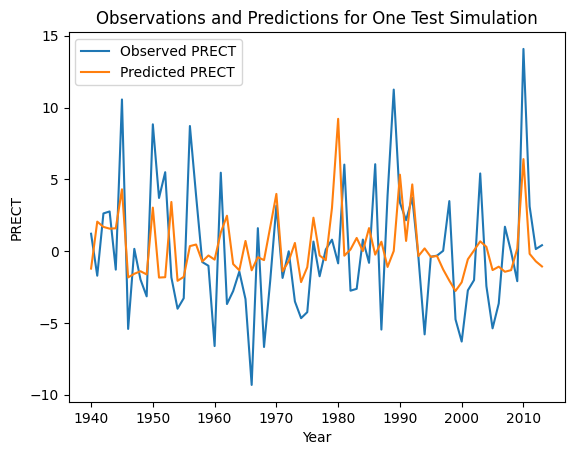

In [23]:
plt.plot(actual_pred_df['Year'], actual_pred_df['Actual PRECT'], label='Observed PRECT')
plt.plot(actual_pred_df['Year'], actual_pred_df['Predicted PRECT'], label='Predicted PRECT')
plt.xlabel('Year')
plt.ylabel('PRECT')
plt.title('Observations and Predictions for One Test Simulation')
plt.legend()
plt.show()

In [24]:
train_loss_dict = dict()

valid_loss_dict = dict()

for i in range(len(train_losses)):
    train_loss_dict[i+1] = train_losses[i]
    valid_loss_dict[i+1] = valid_losses[i]

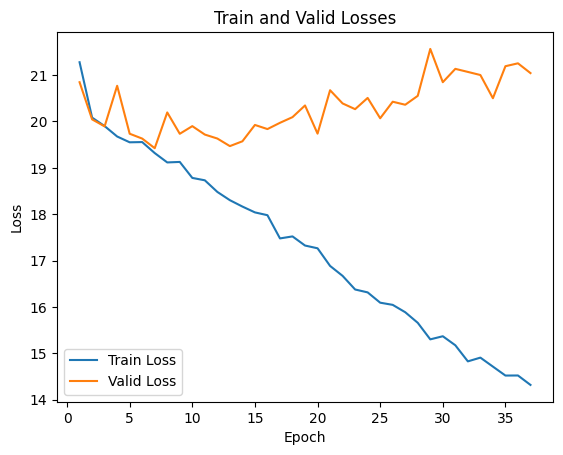

In [25]:
train_loss_df = pd.DataFrame(list(train_loss_dict.items()), columns=['Epoch', 'Train Loss'])
valid_loss_df = pd.DataFrame(list(valid_loss_dict.items()), columns=['Epoch', 'Valid Loss'])

# Merge the DataFrames on 'Epoch' column
merged_df = pd.merge(train_loss_df, valid_loss_df, on='Epoch')

# Plot the losses
plt.plot(merged_df['Epoch'], merged_df['Train Loss'], label='Train Loss')
plt.plot(merged_df['Epoch'], merged_df['Valid Loss'], label='Valid Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Valid Losses')
plt.legend()
plt.show()

https://arxiv.org/pdf/1904.03392.pdf
- see figure 3b

# XAI

In [45]:
!pip install cartopy

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 84.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 223.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 279.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 318.7 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [49]:
!pip install captum

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.1 MB/s eta 0:00:00a 0:00:01


/home/sqz4dh/.local/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1356: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


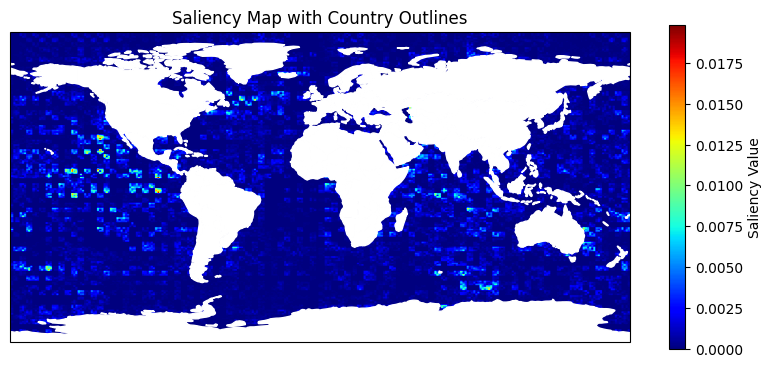

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from PIL import Image
from cartopy.util import add_cyclic_point
import cartopy.io.shapereader as shpreader
import torch
import numpy as np
import cartopy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from captum.attr import Saliency
from captum.attr import visualization as viz
from PIL import Image

longitude = ds2['lon'].values
latitude = ds2['lat'].values
# Generate a sample input tensor
input_data = X_test[98].unsqueeze(0)  # Example input data

# Create a Saliency object for your model
saliency = Saliency(model_best_weights)

# Compute the saliency map
saliency_map = saliency.attribute(input_data.to(device))

# Convert saliency map to NumPy array
saliency_map_np = saliency_map.cpu().detach().numpy()

saliency_map_np = np.flipud(saliency_map_np.squeeze())

# Resize the saliency map to match latitude and longitude dimensions
saliency_map_resized = np.array(Image.fromarray(saliency_map_np).resize((len(longitude), len(latitude))))

# Add cyclic point to the data
saliency_map_cyclic, longitude_cyclic = add_cyclic_point(saliency_map_resized, coord=longitude)

# Plot the saliency map
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Overlay the saliency map
img = ax.imshow(saliency_map_cyclic, origin='upper', extent=[longitude_cyclic.min(), longitude_cyclic.max(), latitude.min(), latitude.max()], transform=ccrs.PlateCarree(), cmap='jet')

# Add country outlines and fill them in white
shpfilename = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

for country in countries:
    ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor='white', edgecolor='white')

cbar = plt.colorbar(img, ax=ax, orientation='vertical', shrink=0.7)
cbar.set_label('Saliency Value')

plt.title('Saliency Map with Country Outlines')
plt.show()


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1356: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "
/home/sqz4dh/.local/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/sqz4dh/.local/lib/python3.10/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.w

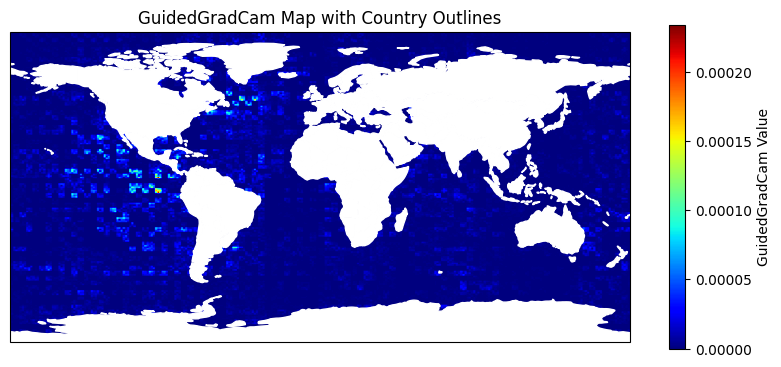

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from PIL import Image
from cartopy.util import add_cyclic_point
import cartopy.io.shapereader as shpreader
import torch
import numpy as np
from captum.attr import GuidedGradCam
from PIL import Image

# Generate a sample input tensor
input_data = X_test[98].unsqueeze(0)  # Example input data

# Create a GuidedGradCam object for your model
guided_gradcam = GuidedGradCam(model_best_weights, model_best_weights.conv3)  # Example target layer

# Compute the saliency map
saliency_map = guided_gradcam.attribute(input_data.to(device), 0)

# Convert saliency map to NumPy array
saliency_map_np = saliency_map.cpu().detach().numpy()

saliency_map_np = np.mean(np.abs(saliency_map_np), axis=0)
# Flip the saliency map array to match the coordinate system expected by cartopy
saliency_map_np = np.flipud(saliency_map_np)

# Resize the saliency map to match latitude and longitude dimensions
saliency_map_resized = np.array(Image.fromarray(saliency_map_np).resize((len(longitude), len(latitude))))

# Add cyclic point to the data
saliency_map_cyclic, longitude_cyclic = add_cyclic_point(saliency_map_resized, coord=longitude)

# Plot the saliency map
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Overlay the saliency map
img = ax.imshow(saliency_map_cyclic, origin='upper', extent=[longitude_cyclic.min(), longitude_cyclic.max(), latitude.min(), latitude.max()], transform=ccrs.PlateCarree(), cmap='jet')

# Add country outlines
shpfilename = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

for country in countries:
    ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor='white', edgecolor='white')

cbar = plt.colorbar(img, ax=ax, orientation='vertical', shrink=0.7)
cbar.set_label('GuidedGradCam Value')

plt.title('GuidedGradCam Map with Country Outlines')
plt.show()


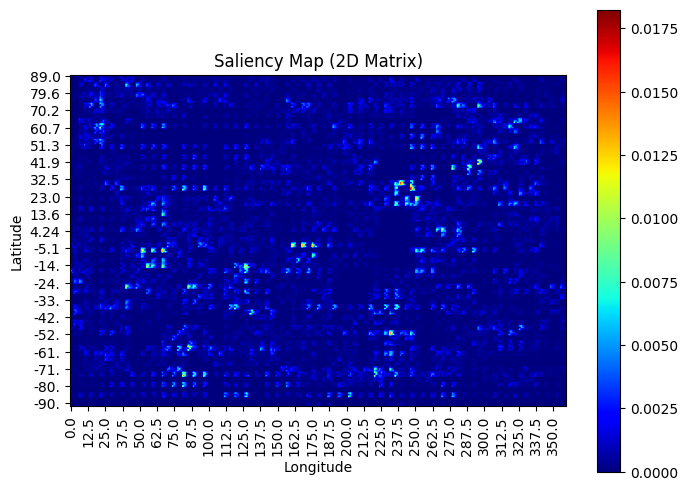

In [58]:
# View saliency_map_np as a 2D matrix
# Reorder the saliency map array to match the coordinate system expected by cartopy
saliency_map_np = np.flipud(saliency_map_np.squeeze())

plt.figure(figsize=(8, 6))
plt.imshow(saliency_map_np, cmap='jet')

# Set x-axis ticks and labels using longitude values, displaying every 10th tick
plt.xticks(np.arange(0, len(ds2['lon']), 10), ds2['lon'].values[::10], rotation='vertical')
plt.xlabel('Longitude')

# Set y-axis ticks and labels using latitude values, displaying every 10th tick
plt.yticks(np.arange(0, len(ds2['lat']), 10), [str(i)[:4] for i in ds2['lat'].values[::10][::-1]])
plt.ylabel('Latitude')

plt.colorbar()
plt.title('Saliency Map (2D Matrix)')
plt.show()


Apply a mask to make sure the zero values aren't included at all?